In [20]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, TFTrainer, TFTrainingArguments
from transformers import DistilBertTokenizerFast
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
training_data = pd.read_csv("Corona_NLP_train.csv", encoding = "ISO-8859-1")
testing_data = pd.read_csv("Corona_NLP_test.csv", encoding = "ISO-8859-1")

In [3]:
def ConvertToNumeric(x):
    if x == "Positive":
        return 3
    elif x == "Extremely Positive":
        return 4
    elif x == "Neutral":
        return 2
    elif x == "Negative":
        return 1
    else:
        return 0

def preprocess(text):
    new_text = []


    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [4]:
training_data.drop(["UserName", "ScreenName", "Location", "TweetAt"], axis = 1, inplace=True)
training_data.Sentiment = training_data.Sentiment.apply(ConvertToNumeric)
training_data.OriginalTweet = training_data.OriginalTweet.apply(preprocess)

testing_data.drop(["UserName", "ScreenName", "Location", "TweetAt"], axis = 1, inplace=True)
testing_data.Sentiment = testing_data.Sentiment.apply(ConvertToNumeric)
testing_data.OriginalTweet = testing_data.OriginalTweet.apply(preprocess)

training_data.dropna(inplace=True)
testing_data.dropna(inplace=True)

In [5]:
X_training_data = training_data.drop(["Sentiment"], axis = 1)
# Y_training_data = tf.keras.utils.to_categorical(training_data.Sentiment)
Y_training_data = training_data.Sentiment

X_testing_data = testing_data.drop(["Sentiment"], axis = 1)
# Y_testing_data = tf.keras.utils.to_categorical(testing_data.Sentiment)
Y_testing_data = testing_data.Sentiment

In [6]:
Training_data_list = []
Testing_data_list = []

for i in X_training_data.values:
    for j in i:
        if j != None:
            Training_data_list.append(j)

for i in X_testing_data.values:
    for j in i:
        if j != None:
            Testing_data_list.append(j)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(Training_data_list, Y_training_data, test_size = 0.1,
                                                  random_state=4, stratify=Y_training_data)

In [8]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [9]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(Testing_data_list, truncation=True, padding=True, max_length=256)

In [10]:
training_dataset_final = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
validation_dataset_final = tf.data.Dataset.from_tensor_slices((dict(val_encodings), y_val))
testing_dataset_final = tf.data.Dataset.from_tensor_slices((dict(test_encodings), Y_testing_data))

In [11]:
from transformers import TFDistilBertForSequenceClassification
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 5)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'vocab_projector', 'vocab_layer_norm', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=["accuracy"]) # can also use any keras loss fn
model.fit(training_dataset_final.shuffle(1000).batch(16), epochs=3, batch_size=16)

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2316/2316 [==============================] - 428s 182ms/step - loss: 0.6989 - accuracy: 0.7249
Epoch 2/3
2316/2316 [==============================] - 424s 183ms/step - loss: 0.3720 - accuracy: 0.8664
Epoch 3/3
2316/2316 [===========================

In [13]:
model.evaluate(validation_dataset_final.batch(16))

258/258 [==============================] - 16s 60ms/step - loss: 0.6061 - accuracy: 0.8088


[0.606127917766571, 0.8087949752807617]

In [14]:
model.evaluate(testing_dataset_final.batch(16))

238/238 [==============================] - 9s 35ms/step - loss: 0.7145 - accuracy: 0.7770


[0.7144994735717773, 0.7769879102706909]

In [15]:
output = model.predict(testing_dataset_final.batch(16))

In [16]:
y_pred = np.argmax(output.logits, axis = 1)

<AxesSubplot:>

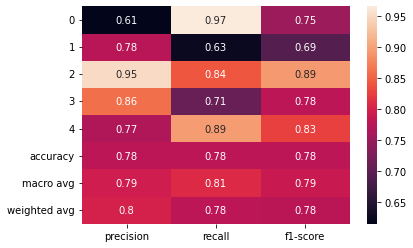

In [23]:
clf_report = classification_report(Y_testing_data, y_pred, output_dict=True)
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

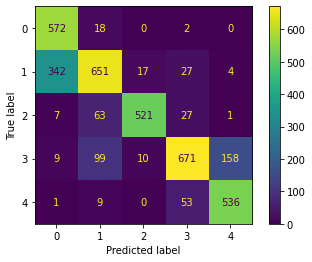

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix(Y_testing_data, y_pred))
disp.plot()